> **Copyright &copy; 2020 CertifAI Sdn. Bhd.**<br>
 **Copyright &copy; 2021 CertifAI Sdn. Bhd.**<br>
 <br>
This program and the accompanying materials are made available under the
terms of the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). \
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS, WITHOUT
WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the
License for the specific language governing permissions and limitations
under the License. <br>
<br>**SPDX-License-Identifier: Apache-2.0**> 

# 05 - Anomaly Detection Using Machine Learning Techniques

Authored by: [Kian Yang Lee](https://github.com/KianYang-Lee) - kianyang.lee@certifai.ai

## Notebook Description
This tutorial will showcase different machine learning approached which can be applied to search for anomalies. All the techniques is readily available in Scikit-learn library. An exercise section is attached for you to practice and hone your skills. Do make good use of it.

By the end of this tutorial, you will be able to:

1. Prepare dataset to be feed into anomaly detection algorithms
2. Apply different anomaly detection algorithms readily accessible from Scikit-learn API
3. Compare and contrast performance of anomaly detection algorithms

## Notebook Outline
Below is the outline for this tutorial:
1. [Notebook Configurations](#configuration)
2. [Dataset](#dataset)
3. [Basic Analytics](#analytics)
4. [Model Development](#model-dev)
    * [Isolation Forest](#isolation-forest)
    * [Minimum Covariance Determinant](#minimum-cov-determinant)
    * [Local Outlier Factor (LOF)](#lof)
    * [One-class Support Vector Machine (OCSVM)](#ocsvm)
5. [Evaluation](#evaluation)
6. [Exercise](#exercise)
7. [Reference](#reference)
8. [Bonus](#bonus)

## <a name="configuration">Notebook Configurations</a>
Following are the modules that will be used for this tutorial. This notebook will heavily use `sklearn` as they provide great APIs when for building deep learning models. You can find out more about them [here](https://scikit-learn.org/).

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
import sys
import json
from pathlib import Path

# configure random state for reproducibility
seed = 38
np.random.seed(seed)

## <a name="dataset">Dataset</a>
We would be using the Twitter Volume of Apple Inc. dataset as the training dataset and Twitter Volume of Google Inc. dataset as the test dataset. Both datasets contains historical tweet mentions of the said corporate in Twitter measured on every 5 minutes for a periood of time. Since this is a historical data, anomalous data are identified and annotated by domain experts and provided in json format. You can read more about the dataset [here](https://github.com/numenta/NAB/tree/master/data/realTweets)

In [2]:
# path specification
dataset_dir_path = Path().resolve().parent.parent/'datasets'
label_dir_path = dataset_dir_path/'labels'
data_dir_path = dataset_dir_path/'tweets'
training_file_name = 'Twitter_volume_AAPL.csv' 
test_file_name = 'Twitter_volume_GOOG.csv' 

# import dataset
df_train = pd.read_csv(data_dir_path/training_file_name)
df_test = pd.read_csv(data_dir_path/test_file_name)

# import label
labels_file_path = label_dir_path/'labels.json'
with open(labels_file_path, 'r') as f:
    labeled_anomalies = json.load(f)

## <a name="analytics">Basic Analytics</a>
Let's do some basic analytics and see what nugget can we find out of the training dataset! Let first find out the number of rows and columns of the training dataset.

**Note: Since we are not supposed to know any information about the test dataset, we will not perform any analytics on it.**

In [3]:
# inspect first 15 rows of data
df_train.head(15)

,timestamp,value
0,2015-02-26 21:42:53,104
1,2015-02-26 21:47:53,100
2,2015-02-26 21:52:53,99
3,2015-02-26 21:57:53,154
4,2015-02-26 22:02:53,120
5,2015-02-26 22:07:53,90
6,2015-02-26 22:12:53,92
7,2015-02-26 22:17:53,71
8,2015-02-26 22:22:53,339
9,2015-02-26 22:27:53,178


We can see that there are two columns, timestamp and value. We are also interested in the data type for each column.

In [4]:
# compute dtype
for column in df_train.columns:
    print(f"The data type for '{column}' column is: {df_train[column].dtype}")

The data type for 'timestamp' column is: object
The data type for 'value' column is: int64


We see that the data type for 'timestamp' is not `datetime`, when evidently it should be. `datetime` data type is special in the sense that they are treated differently from other data types. We will proceed to convert it to the right data type.

In [5]:
# convert 'timestamp' column dtype to datetime
df_train.timestamp = pd.to_datetime(df_train.timestamp)
df_test.timestamp = pd.to_datetime(df_test.timestamp)

Now, we will compute the descriptive statistics.

In [6]:
# compute descriptive statistics
df_train.describe()

,value
count,15902.000000
mean,85.552320
std,321.050721
min,0.000000
25%,29.000000
50%,47.000000
75%,76.000000
max,13479.000000


We see the the mean is around 85.6. An interesting note is the high standard deviation, which is 321.1. The 25th, 50th and 75th percentile value all shows values at the relatively low-end, which are less than 76. This shows that the data is actually has a large spread. A good way to confirm this is by visualizing a scatter plot of value against time.

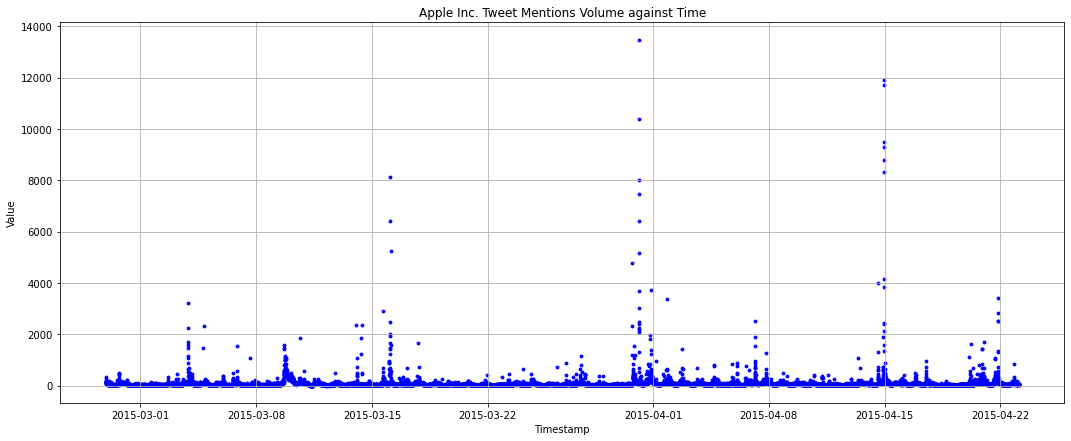

In [7]:
# plot scatter plot 
fig, ax = plt.subplots()
fig.set_size_inches(18, 7)
ax.set_title("Apple Inc. Tweet Mentions Volume against Time")
ax.grid(b=True)
ax.set_xlabel("Timestamp")
ax.set_ylabel("Value")
ax.scatter(
    x=df_train['timestamp'],
    y=df_train['value'],
    s=8, color='blue', label='Data');

Now that we get a sense of the raw data, let's make use of the information provided in `labels.json` to check which of these data are annotated as `anomaly` by the domain experts.

In [8]:
# display anomalies in json file
list_of_train_anomalies = labeled_anomalies[training_file_name]

print("The list of anomalies as recorded in 'labels.json' file is:")
print("\n")
print(list_of_train_anomalies)

The list of anomalies as recorded in 'labels.json' file is:


['2015-03-03 21:07:53', '2015-03-09 17:32:53', '2015-03-16 02:57:53', '2015-03-31 03:27:53']


We see that there are four anomalies labeled in the dataset. To make the process of model development easier, we will create another column named "anomaly_label" and give it a value of 1 for anomalous data and 0 for normal data. 

In [9]:
# insert new column and write 1 if sample is anomaly else 0
df_train['anomaly_label'] = df_train['timestamp'].isin(labeled_anomalies[training_file_name]).astype(int)
df_test['anomaly_label'] = df_test['timestamp'].isin(labeled_anomalies[test_file_name]).astype(int)

Also, it is useful to know what is the underlying anomalous data ratio to the dataset, as this is a hyperparameter required by many `sklearn` model parameters. In `sklearn` documentation, it is known as `contamination`, which borrows the concept of outliers "contaminating" the dataset (since they are not supposed to be there in the first place). Let us compute the `contamination` value.

In [10]:
# compute ratio of anomalies to total number of samples
contamination = df_train['anomaly_label'].sum() / len(df_train)

We will plot scatter plot that highlights which of these data are anomalies. This gives us a better sense of why that particular instance(s) are anomalous.

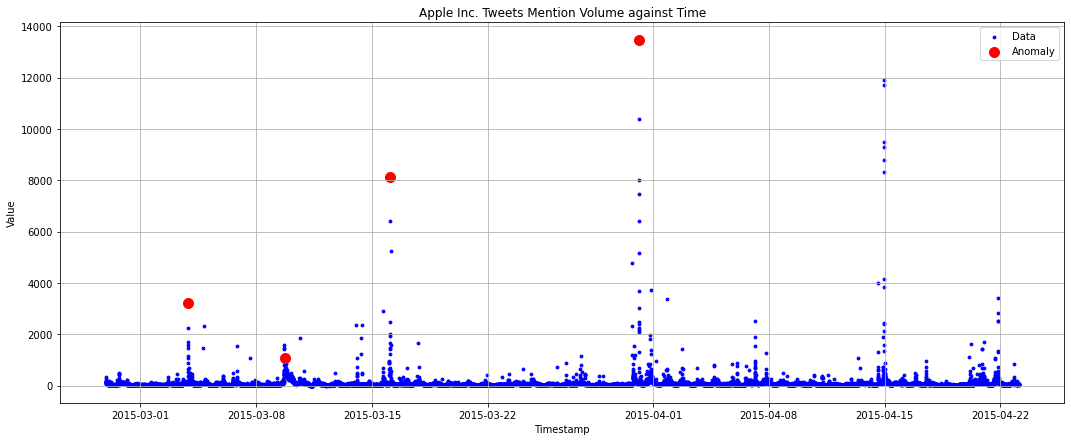

In [11]:
# plot scatter plot 
fig, ax = plt.subplots()
fig.set_size_inches(18, 7)
ax.set_title("Apple Inc. Tweets Mention Volume against Time")
ax.grid(b=True)
ax.set_xlabel("Timestamp")
ax.set_ylabel("Value")
ax.scatter(x=df_train['timestamp'], 
           y=df_train['value'],
           s=8, color='blue', label='Data')
ax.scatter(x=df_train['timestamp'][df_train['anomaly_label']==1], 
           y=df_train['value'][df_train['anomaly_label']==1], 
           s=100, c='red', label='Anomaly')
ax.legend();

We can see that the four anomalies are dispersed at different points in time and are quite far apart. Most of them appeared to have a sudden spike in terms of value when compared to the neighboring data. Next, we will separate out the feature and label for modeling purpose.

In [12]:
# split features and label
X_train = df_train.value.to_numpy().reshape(-1, 1)
X_test = df_test.value.to_numpy().reshape(-1, 1)

## <a name="model-dev">Model Development</a>
The `scikit-learn` library provides a number of API for applying anomaly detection techniques for the tasks at hand. We will be guiding you through four methods and compare their performance in detecting anomalies.

Each model will first be instantiated, then fit on the training dataset. The model will then predict which samples in the dataset are outliers (anomalies) and which are not (inliers/normal data).

### <a name=isolation-forest>a) Isolation Forest</a>

Isolation Forest, or `iForest` for short, is a tree-based anomaly detection algorithm. It is based on the assumptions that anomalies are markedly different from normal data. Thus, when using a tree-based model in the attempt of isolating a single sample, it would only takes the least amount of attempts/paths to isolate an anomaly. Below is a quote from the original paper [here](https://ieeexplore.ieee.org/abstract/document/4781136)

```
… our proposed method takes advantage of two anomalies’ quantitative properties: i) they are the minority consisting of fewer instances and ii) they have attribute-values that are very different from those of normal instances.
```

<div style="text-align: right"> — Isolation Forest, 2008. </div>

The `sklearn` library provides an implementation of Isolation Forest in the [IsolationForest class](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html). We will build the model here using `sklearn` API.

Perhaps the most important hyperparameter in the model is the “contamination” argument, which is used to help estimate the number of outliers in the dataset. This is a value between 0.0 and 0.5 and by default is set to 0.1. 

In [13]:
# instantiate the model by specifying random state and contamination value
iForest = IsolationForest(random_state=seed, contamination=0.05)
iForest.fit(X_train)

IsolationForest(contamination=0.05, random_state=38)

`iForest` model is instantiated and fit to the training data in just 2 lines of code. Next, let's inspect its performance when used to predict on the train dataset. Do note that the model by default generates 1 for inliers (normal data) and -1 for outliers (anomalies) as the model is trying to determine whether the data is an inlier or not, as documented in the API descriptions.

To avoid confusion, we will convert the labels so that 1 signifies anomalies and 0 signifies normal data.

In [14]:
# perform prediction
iForest_preds = iForest.predict(X_train)

# converting label of 1 to 0 and -1 to 1
iForest_preds[iForest_preds == 1] = 0
iForest_preds[iForest_preds == -1] = 1

# writing prediction results onto training DataFrame for result comparison
df_train['iForest_preds'] = iForest_preds

We can identify which sample(s) are classified as anomalies by the algorithm through visualization.

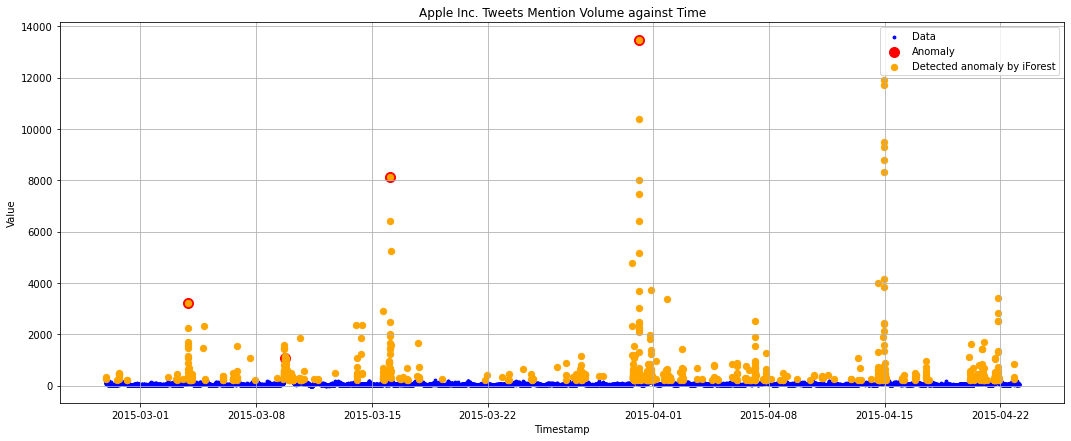

In [15]:
# plot scatter plot 
fig, ax = plt.subplots()
fig.set_size_inches(18, 7)
ax.set_title("Apple Inc. Tweets Mention Volume against Time")
ax.grid(b=True)
ax.set_xlabel("Timestamp")
ax.set_ylabel("Value")
ax.scatter(x=df_train['timestamp'], 
           y=df_train['value'],
           s=8, color='blue', label='Data')
ax.scatter(x=df_train['timestamp'][df_train['anomaly_label']==1], 
           y=df_train['value'][df_train['anomaly_label']==1], 
           s=100, c='red', label='Anomaly')
ax.scatter(x=df_train['timestamp'][df_train['iForest_preds']==1], 
           y=df_train['value'][df_train['iForest_preds']==1], 
           s=40, c='orange', label='Detected anomaly by iForest')
ax.legend();

Based on the visualization, the model managed to detect 4 out of 4 anomalies, albeit with many false positives too (normal data but classified as anomalous by the model).

### <a name=minimum-cov-determinant>b) Minimum Covariance Determinant </a>

If the input variables have a Gaussian distribution, then simple statistical methods can be used to detect outliers.

For example, if the dataset has two input variables and both are Gaussian, then the feature space forms a multi-dimensional Gaussian and knowledge of this distribution can be used to identify values far from the distribution.

This approach can be generalized by defining a hypersphere (ellipsoid) that covers the normal data, and data that falls outside this shape is considered an outlier. An efficient implementation of this technique for multivariate data is known as the Minimum Covariance Determinant, or MCD for short. More information about this technique can be found [here](https://arxiv.org/abs/1709.07045). Below is a quote from the original paper:

```
The Minimum Covariance Determinant (MCD) method is a highly robust estimator of multivariate location and scatter, for which a fast algorithm is available. […] It also serves as a convenient and efficient tool for outlier detection.
```
<div style="text-align: right"> — Minimum Covariance Determinant and Extensions, 2017.</div>

The `sklearn` library provides access to this method via the [EllipticEnvelope class](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html).

It, too, provides the “contamination” argument that defines the expected ratio of outliers to be observed in practice.

In [16]:
# instantiate the model by specifying random state and contamination value
ee = EllipticEnvelope(random_state=seed, contamination=0.05)
ee.fit(X_train)

EllipticEnvelope(contamination=0.05, random_state=38)

`EllipticEnvelope` model is instantiated and fit to the training data in just 2 lines of code. Next, let's inspect its performance when used to predict on the train dataset. Do note that the model by default generates 1 for inliers (normal data) and -1 for outliers (anomalies) as the model is trying to determine whether the data is an inlier or not, as documented in the API descriptions.

To avoid confusion, we will convert the labels so that 1 signifies anomalies and 0 signifies normal data.

In [17]:
# perform prediction
ee_preds = ee.predict(X_train)

# converting label of 1 to 0 and -1 to 1
ee_preds[ee_preds == 1] = 0
ee_preds[ee_preds == -1] = 1

# writing prediction results onto training DataFrame for result comparison
df_train['ee_preds'] = ee_preds

We can identify which observations are classified as anomalies by the algorithm through visualization.

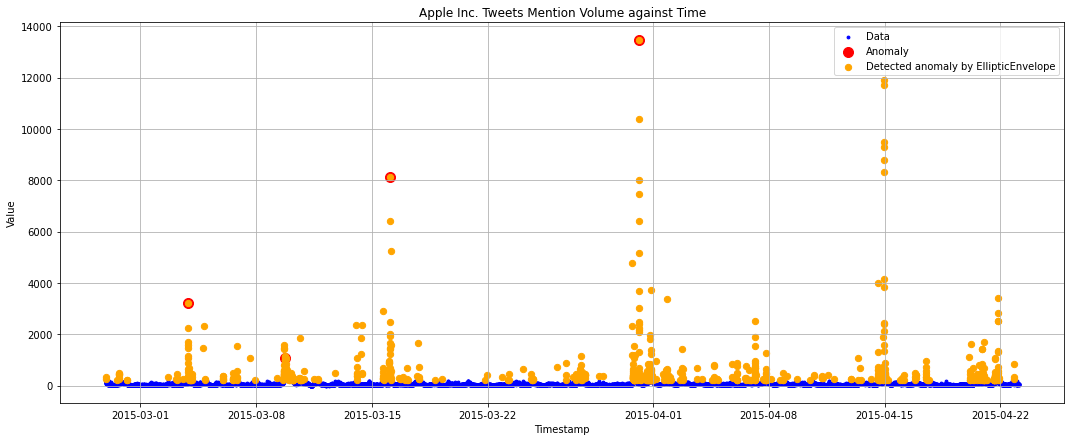

In [18]:
# plot scatter plot 
fig, ax = plt.subplots()
fig.set_size_inches(18, 7)
ax.set_title("Apple Inc. Tweets Mention Volume against Time")
ax.grid(b=True)
ax.set_xlabel("Timestamp")
ax.set_ylabel("Value")
ax.scatter(x=df_train['timestamp'], 
           y=df_train['value'],
           s=8, color='blue', label='Data')
ax.scatter(x=df_train['timestamp'][df_train['anomaly_label']==1], 
           y=df_train['value'][df_train['anomaly_label']==1], 
           s=100, c='red', label='Anomaly')
ax.scatter(x=df_train['timestamp'][df_train['ee_preds']==1], 
           y=df_train['value'][df_train['ee_preds']==1], 
           s=40, c='orange', label='Detected anomaly by EllipticEnvelope')
ax.legend();

Based on the visualization, the model managed to detect 4 out of 4 anomalies, albeit with many false positives too (normal data but classified as anomalous by the model).

### <a name=lof>c) Local Outlier Factor</a>

A simple approach to identifying outliers is to locate those examples that are far from the other examples in the feature space.

This can work well for feature spaces with low dimensionality (few features), although it can become less reliable as the number of features is increased, referred to as the curse of dimensionality.

The local outlier factor, or LOF for short, is a technique that attempts to harness the idea of nearest neighbors for outlier detection. Each example is assigned a scoring of how isolated or how likely it is to be outliers based on the size of its local neighborhood. Those examples with the largest score are more likely to be outliers.

Below is a quote from the original paper, which can be found [here](https://dl.acm.org/doi/10.1145/342009.335388)

```
We introduce a local outlier (LOF) for each object in the dataset, indicating its degree of outlier-ness.
```
<div style="text-align: right"> — LOF: Identifying Density-based Local Outliers, 2000. </div>

`sklearn` provides an implementation of this approach in the [LocalOutlierFactor class](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html).

The model provides the “contamination” argument, that is the expected percentage of outliers in the dataset, be indicated and defaults to 0.1.

In [19]:
# instantiate the model by specifying random state and contamination value
lof = LocalOutlierFactor(contamination=0.05, novelty=True)
lof.fit(X_train)

LocalOutlierFactor(contamination=0.05, novelty=True)

`LocalOutlierFactor` model is instantiated. Next, let's inspect its performance when used to predict on the train dataset. Do note that the model by default generates 1 for inliers (normal data) and -1 for outliers (anomalies) as the model is trying to determine whether the data is an inlier or not, as documented in the API descriptions.

To avoid confusion, we will convert the labels so that 1 signifies anomalies and 0 signifies normal data.

In [20]:
# perform prediction
lof_preds = lof.predict(X_train)

# converting label of 1 to 0 and -1 to 1
lof_preds[lof_preds == 1] = 0
lof_preds[lof_preds == -1] = 1

# writing prediction results onto training DataFrame for result comparison
df_train['lof_preds'] = lof_preds

We can identify which observations are classified as anomalies by the algorithm through visualization.

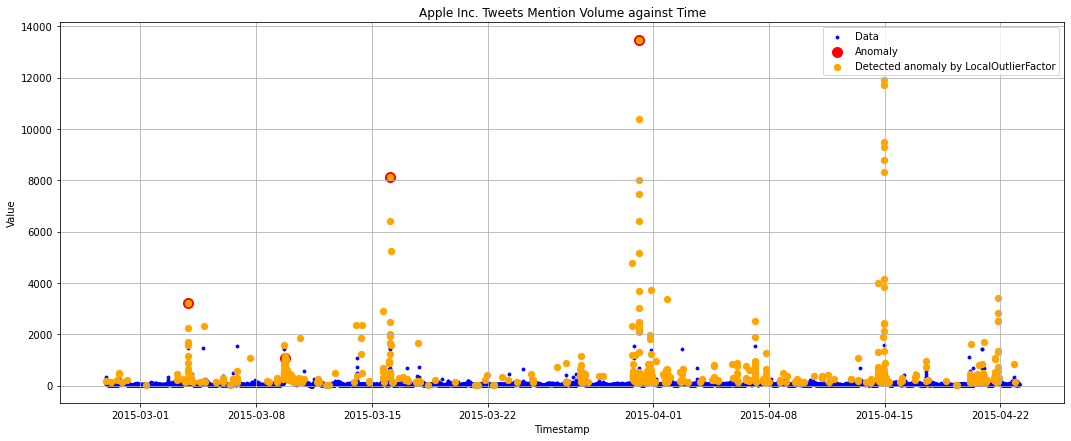

In [21]:
# plot scatter plot 
fig, ax = plt.subplots()
fig.set_size_inches(18, 7)
ax.set_title("Apple Inc. Tweets Mention Volume against Time")
ax.grid(b=True)
ax.set_xlabel("Timestamp")
ax.set_ylabel("Value")
ax.scatter(x=df_train['timestamp'], 
           y=df_train['value'],
           s=8, color='blue', label='Data')
ax.scatter(x=df_train['timestamp'][df_train['anomaly_label']==1], 
           y=df_train['value'][df_train['anomaly_label']==1], 
           s=100, c='red', label='Anomaly')
ax.scatter(x=df_train['timestamp'][df_train['lof_preds']==1], 
           y=df_train['value'][df_train['lof_preds']==1], 
           s=40, c='orange', label='Detected anomaly by LocalOutlierFactor')
ax.legend();

Based on the visualization, the model managed to detect 4 out of 4 anomalies, albeit with many false positives too (normal data but classified as anomalous by the model).

### <a name=ocsvm> d) One-Class SVM (OCSVM)</a>

The support vector machine, or SVM, algorithm developed initially for binary classification can be used for one-class classification.

When modeling one class, the algorithm captures the density of the majority class and classifies examples on the extremes of the density function as outliers. This modification of SVM is referred to as One-Class SVM. Below is a quote from the original paper, which can be read [here](https://dl.acm.org/doi/10.1162/089976601750264965).

```
… an algorithm that computes a binary function that is supposed to capture regions in input space where the probability density lives (its support), that is, a function such that most of the data will live in the region where the function is nonzero.
```
<div style="text-align: right"> — Estimating the Support of a High-Dimensional Distribution, 2001. </div>

Although SVM is a classification algorithm and One-Class SVM is also a classification algorithm, it can be used to discover outliers in input data for both regression and classification datasets.

`sklearn` provides an implementation of one-class SVM in the [OneClassSVM class](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html).

In [22]:
# instantiate the model by specifying random state and contamination value
ocsvm = OneClassSVM(nu=0.05)
ocsvm.fit(X_train)

OneClassSVM(nu=0.05)

`OneClassSVM` model is instantiated. Next, let's inspect its performance when used to predict on the train dataset. Do note that the model by default generates 1 for inliers (normal data) and -1 for outliers (anomalies) as the model is trying to determine whether the data is an inlier or not, as documented in the API descriptions.

To avoid confusion, we will convert the labels so that 1 signifies anomalies and 0 signifies normal data.

In [23]:
# perform prediction
ocsvm_preds = ocsvm.predict(X_train)

# converting label of 1 to 0 and -1 to 1
ocsvm_preds[ocsvm_preds == 1] = 0
ocsvm_preds[ocsvm_preds == -1] = 1

# writing prediction results onto training DataFrame for result comparison
df_train['ocsvm_preds'] = ocsvm_preds

We can identify which observations are classified as anomalies by the algorithm through visualization.

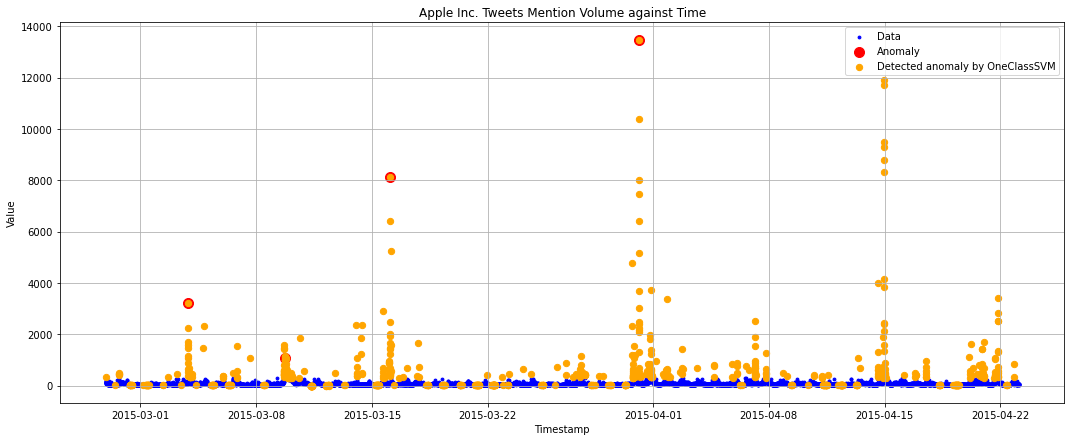

In [24]:
# plot scatter plot 
fig, ax = plt.subplots()
fig.set_size_inches(18, 7)
ax.set_title("Apple Inc. Tweets Mention Volume against Time")
ax.grid(b=True)
ax.set_xlabel("Timestamp")
ax.set_ylabel("Value")
ax.scatter(x=df_train['timestamp'], 
           y=df_train['value'],
           s=8, color='blue', label='Data')
ax.scatter(x=df_train['timestamp'][df_train['anomaly_label']==1], 
           y=df_train['value'][df_train['anomaly_label']==1], 
           s=100, c='red', label='Anomaly')
ax.scatter(x=df_train['timestamp'][df_train['ocsvm_preds']==1], 
           y=df_train['value'][df_train['ocsvm_preds']==1], 
           s=40, c='orange', label='Detected anomaly by OneClassSVM')
ax.legend();

Based on the visualization, the model managed to detect 4 out of 4 anomalies, resulting in 1.0 recall, albeit with many false positives too (normal data but classified as anomalous by the model).

## <a name="evaluation">Evaluation</a>
Since this is a classification task, we will be using the following metrics for model evaluation:
* accuracy
* precision
* recall
* f1-score

We will examine the performance of the model on both the training and test set. But first, let us use our built models to perform anomaly detections on test dataset. We will write a customized function to perform model prediction and visualization to save hassles.

,timestamp,value,anomaly_label,"IsolationForest(contamination=0.05, random_state=38)_preds","EllipticEnvelope(contamination=0.05, random_state=38)_preds","LocalOutlierFactor(contamination=0.05, novelty=True)_preds",OneClassSVM(nu=0.05)_preds
0,2015-02-26 21:42:53,35,0,0,0,0,0
1,2015-02-26 21:47:53,41,0,0,0,0,0
2,2015-02-26 21:52:53,32,0,0,0,0,0
3,2015-02-26 21:57:53,36,0,0,0,0,0
4,2015-02-26 22:02:53,32,0,0,0,0,0
...,...,...,...,...,...,...,...
15837,2015-04-22 21:27:53,58,0,0,0,0,0
15838,2015-04-22 21:32:53,50,0,0,0,0,0
15839,2015-04-22 21:37:53,32,0,0,0,0,0
15840,2015-04-22 21:42:53,72,0,0,0,0,0


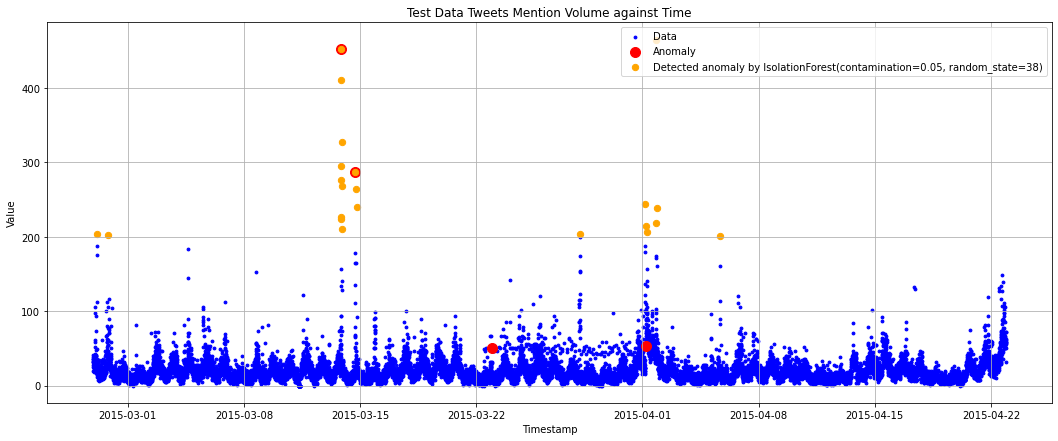

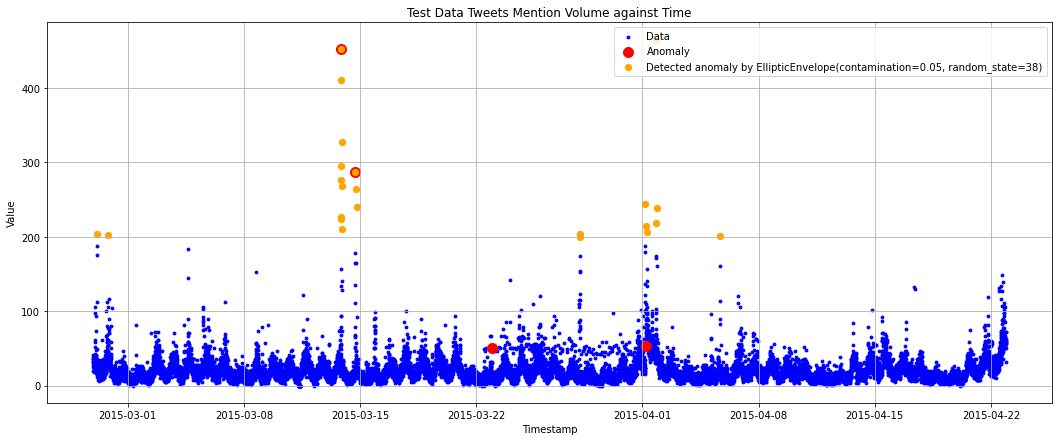

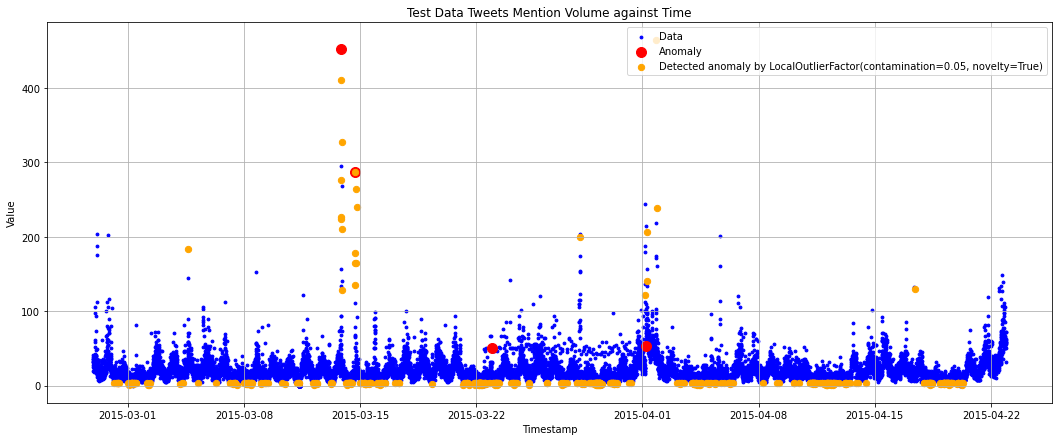

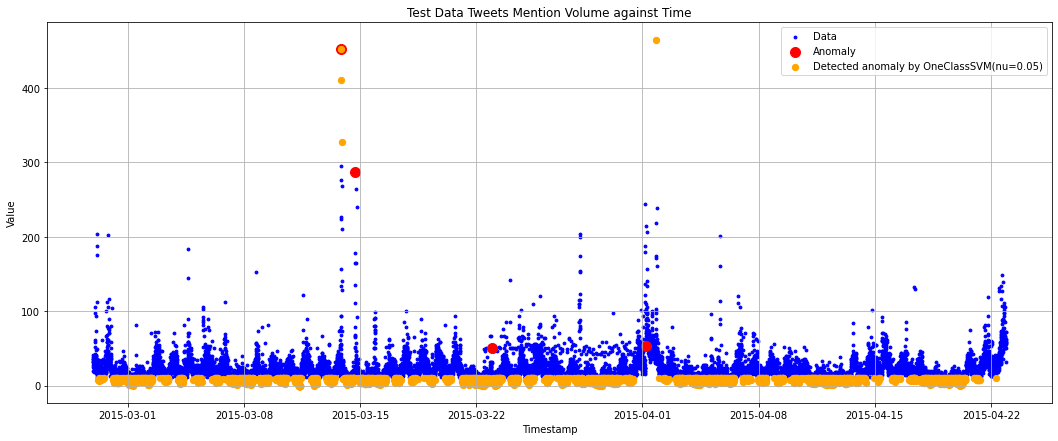

In [25]:
def predict_and_plotting(model, features: np.ndarray, data: pd.DataFrame) -> pd.DataFrame:
    """Perform model predictions on input data and visualize prediction results in scatter plot. Return DataFrame with prediction results written on it."""
    # perform prediction
    model_preds = model.predict(features)

    # converting label of 1 to 0 and -1 to 1
    model_preds[model_preds == 1] = 0
    model_preds[model_preds == -1] = 1

# writing prediction results onto training DataFrame for result comparison
    data[str(model) + '_preds'] = model_preds

    # plot scatter plot 
    fig, ax = plt.subplots()
    fig.set_size_inches(18, 7)
    ax.set_title("Test Data Tweets Mention Volume against Time")
    ax.grid(b=True)
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Value")
    ax.scatter(x=data['timestamp'], 
               y=data['value'],
               s=8, color='blue', label='Data')
    ax.scatter(x=data['timestamp'][data['anomaly_label']==1], 
               y=data['value'][data['anomaly_label']==1], 
               s=100, c='red', label='Anomaly')
    ax.scatter(x=data['timestamp'][data[str(model) + '_preds']==1], 
               y=data['value'][data[str(model) + '_preds']==1], 
               s=40, c='orange', label='Detected anomaly by ' + str(model))
    ax.legend();
    
    return data

predict_and_plotting(iForest, X_test, df_test)
predict_and_plotting(ee, X_test, df_test)
predict_and_plotting(lof, X_test, df_test)
predict_and_plotting(ocsvm, X_test, df_test)

In [26]:
# compute performance metrics for model on training dataset
for idx in range(3, 7):
    print(f"MODEL PERFORMANCE FOR {df_train.columns[idx]}")
    print(classification_report(y_true=df_train.loc[:, 'anomaly_label'], y_pred=df_train.iloc[:, idx]))


MODEL PERFORMANCE FOR iForest_preds
              precision    recall  f1-score   support

           0       1.00      0.95      0.98     15898
           1       0.01      1.00      0.01         4

    accuracy                           0.95     15902
   macro avg       0.50      0.98      0.49     15902
weighted avg       1.00      0.95      0.98     15902

MODEL PERFORMANCE FOR ee_preds
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     15898
           1       0.01      1.00      0.01         4

    accuracy                           0.95     15902
   macro avg       0.50      0.98      0.49     15902
weighted avg       1.00      0.95      0.97     15902

MODEL PERFORMANCE FOR lof_preds
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     15898
           1       0.00      0.75      0.01         4

    accuracy                           0.96     15902
   macro avg       0.50      

In [27]:
# compute performance metrics for model on test dataset
for idx in range(3, 7):
    print(f"MODEL PERFORMANCE FOR {df_test.columns[idx]}")
    print(classification_report(y_true=df_test.loc[:, 'anomaly_label'], y_pred=df_test.iloc[:, idx]))

MODEL PERFORMANCE FOR IsolationForest(contamination=0.05, random_state=38)_preds
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15838
           1       0.09      0.50      0.15         4

    accuracy                           1.00     15842
   macro avg       0.55      0.75      0.58     15842
weighted avg       1.00      1.00      1.00     15842

MODEL PERFORMANCE FOR EllipticEnvelope(contamination=0.05, random_state=38)_preds
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15838
           1       0.09      0.50      0.15         4

    accuracy                           1.00     15842
   macro avg       0.54      0.75      0.57     15842
weighted avg       1.00      1.00      1.00     15842

MODEL PERFORMANCE FOR LocalOutlierFactor(contamination=0.05, novelty=True)_preds
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    

Based on the above performance metrics, it can be seen that none of the models were able to detect all 4 anomalies in the test dataset. Nevertheless, out of the 4 models, `IsolationForest` and `EllipticEnvelope` have the best performance, as they both scored 0.09 for precision, 0.50 for recall, and 0.15 for F1-score on detecting anomalies,

Next section is Exercise section.

## <a name="exercise">Exercise</a>

This exercise section is attached for you to practice and hone your skills. Try your best effort to complete it without referring to the solution.

### Notebook Configurations
You can import any module that you wish to use for this exercise. However, if you run the cells from the start of this notebook, most probably all the modules which you need had already been imported at this point.

In [28]:
# import modules
### BEGIN SOLUTION


### END SOLUTION

### Dataset
**INSTRUCTIONS**: Please perform anomaly detection task by reversing the datasets used, ie. use "Twitter_volume_GOOG.csv" as training dataset and "Twitter_volume_AAPL.csv" as test dataset.

In [29]:
# import training and test dataset
### BEGIN SOLUTION
dataset_dir_path = Path().resolve().parent.parent/'datasets'
data_dir_path = dataset_dir_path/'tweets'
training_file_name = 'Twitter_volume_GOOG.csv' 
test_file_name = 'Twitter_volume_AAPL.csv' 

df_train = pd.read_csv(data_dir_path/training_file_name)
df_test = pd.read_csv(data_dir_path/test_file_name)
### END SOLUTION

# import anomaly label from json file
### BEGIN SOLUTION
labels_file_path = data_dir_path/'labels.json'
with open(labels_file_path, 'r') as f:
    labeled_anomalies = json.load(f)
### END SOLUTION

### Basic Analytics
**INSTRUCTIONS**: Perform some basic analytics on the dataset by following the guidelines that are provided in each cell.

In [30]:
# inspect first 15 rows of data
### BEGIN SOLUTION
df_train.head(15)
### END SOLUTION

,timestamp,value
0,2015-02-26 21:42:53,35
1,2015-02-26 21:47:53,41
2,2015-02-26 21:52:53,32
3,2015-02-26 21:57:53,36
4,2015-02-26 22:02:53,32
5,2015-02-26 22:07:53,25
6,2015-02-26 22:12:53,33
7,2015-02-26 22:17:53,20
8,2015-02-26 22:22:53,38
9,2015-02-26 22:27:53,28


In [31]:
# compute dtype
### END SOLUTION
for column in df_train.columns:
    print(f"The data type for '{column}' column is: {df_train[column].dtype}")
### END SOLUTION

The data type for 'timestamp' column is: object
The data type for 'value' column is: int64


In [32]:
# convert 'timestamp' column dtype to datetime
### BEGIN SOLUTION
df_train.timestamp = pd.to_datetime(df_train.timestamp)
df_test.timestamp = pd.to_datetime(df_test.timestamp)
### END SOLUTION

In [33]:
# compute descriptive statistics
### BEGIN SOLUTION
df_train.describe()
### END SOLUTION

,value
count,15842.000000
mean,20.736397
std,18.564627
min,0.000000
25%,11.000000
50%,16.000000
75%,26.000000
max,465.000000


In [35]:
# display anomalies in json file
### BEGIN SOLUTION
list_of_train_anomalies = labeled_anomalies[training_file_name]
### END SOLUTION

print("The list of anomalies as recorded in 'labels.json' file is:")
print("\n")
print(list_of_train_anomalies)

The list of anomalies as recorded in 'labels.json' file is:


['2015-03-13 20:22:53', '2015-03-14 16:27:53', '2015-03-22 22:52:53', '2015-04-01 05:27:53']


In [36]:
# insert new column and write 1 if sample is anomaly else 0
### BEGIN SOLUTION
df_train['anomaly_label'] = df_train['timestamp'].isin(labeled_anomalies[training_file_name]).astype(int)
df_test['anomaly_label'] = df_test['timestamp'].isin(labeled_anomalies[test_file_name]).astype(int)
### END SOLUTION

In [37]:
# compute ratio of anomalies to total number of samples
### BEGIN SOLUTION
contamination = df_train['anomaly_label'].sum() / len(df_train)
### END SOLUTION

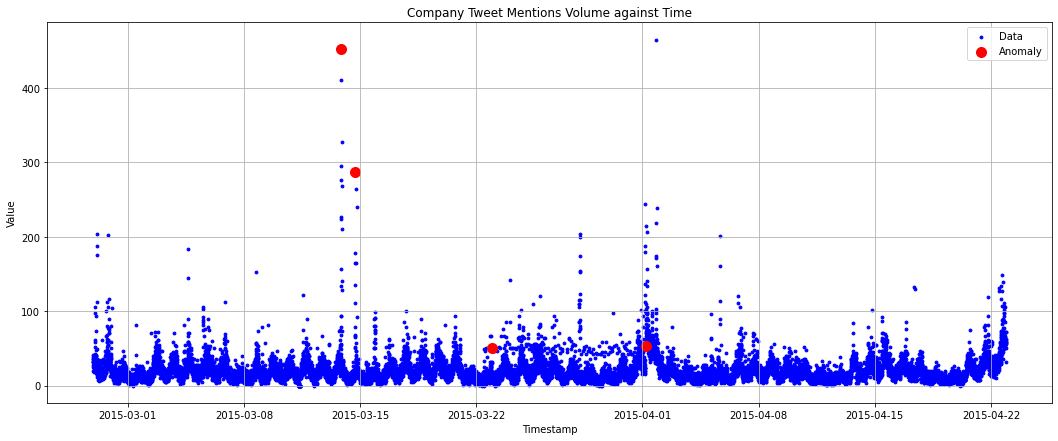

In [38]:
# plot scatter plot 
### BEGIN SOLUTION
fig, ax = plt.subplots()
fig.set_size_inches(18, 7)
ax.set_title("Company Tweet Mentions Volume against Time")
ax.grid(b=True)
ax.set_xlabel("Timestamp")
ax.set_ylabel("Value")
ax.scatter(x=df_train['timestamp'], 
           y=df_train['value'],
           s=8, color='blue', label='Data')
ax.scatter(x=df_train['timestamp'][df_train['anomaly_label']==1], 
           y=df_train['value'][df_train['anomaly_label']==1], 
           s=100, c='red', label='Anomaly')
ax.legend();
### END SOLUTION

In [39]:
# split features and label
### BEGIN SOLUTION
X_train = df_train.value.to_numpy().reshape(-1, 1)
X_test = df_test.value.to_numpy().reshape(-1, 1)
### END SOLUTION

### Model Development
**INSTRUCTIONS**: Choose your preferred machine learning model and develop it using training dataset.

In [57]:
# instantiate the model
### BEGIN SOLUTION
model = IsolationForest(random_state=seed, contamination=0.001)
model.fit(X_train)
### END SOLUTION

IsolationForest(contamination=0.001, random_state=38)

In [58]:
# perform prediction
### BEGIN SOLUTION
model_preds = model.predict(X_train)
### END SOLUTION

# converting label of 1 to 0 and -1 to 1
### BEGIN SOLUTION
model_preds[model_preds == 1] = 0
model_preds[model_preds == -1] = 1
### END SOLUTION

# writing prediction results onto training DataFrame for result comparison
### BEGIN SOLUTION
df_train['model_preds'] = model_preds
### END SOLUTION

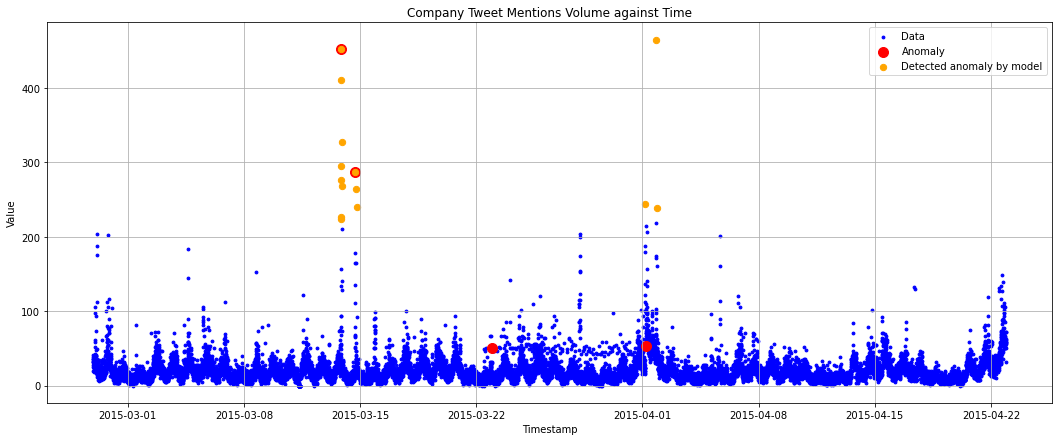

In [59]:
# plot scatter plot of prediction results
### BEGIN SOLUTION
fig, ax = plt.subplots()
fig.set_size_inches(18, 7)
ax.set_title("Company Tweet Mentions Volume against Time")
ax.grid(b=True)
ax.set_xlabel("Timestamp")
ax.set_ylabel("Value")
ax.scatter(x=df_train['timestamp'], 
           y=df_train['value'],
           s=8, color='blue', label='Data')
ax.scatter(x=df_train['timestamp'][df_train['anomaly_label']==1], 
           y=df_train['value'][df_train['anomaly_label']==1], 
           s=100, c='red', label='Anomaly')
ax.scatter(x=df_train['timestamp'][df_train['model_preds']==1], 
           y=df_train['value'][df_train['model_preds']==1], 
           s=40, c='orange', label='Detected anomaly by model')
ax.legend();
### END SOLUTION

### Evaluation
**INSTRUCTIONS:** Follow the guidelines given in the cells to evaluate performance of model.

,timestamp,value,anomaly_label,"IsolationForest(contamination=0.05, random_state=38)_preds","IsolationForest(contamination=0.01, random_state=38)_preds","IsolationForest(contamination=0.005, random_state=38)_preds","IsolationForest(contamination=0.001, random_state=38)_preds"
0,2015-02-26 21:42:53,104,0,1,1,0,0
1,2015-02-26 21:47:53,100,0,1,1,0,0
2,2015-02-26 21:52:53,99,0,1,1,0,0
3,2015-02-26 21:57:53,154,0,1,1,1,0
4,2015-02-26 22:02:53,120,0,1,1,1,0
...,...,...,...,...,...,...,...
15897,2015-04-23 02:27:53,44,0,0,0,0,0
15898,2015-04-23 02:32:53,45,0,0,0,0,0
15899,2015-04-23 02:37:53,48,0,0,0,0,0
15900,2015-04-23 02:42:53,26,0,0,0,0,0


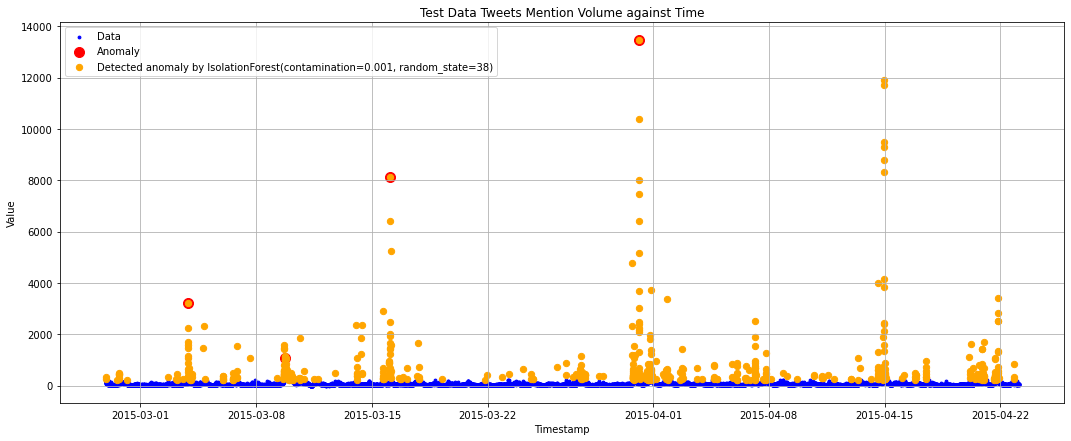

In [60]:
# perform predictions using developed model and write results in the dataframe
### BEGIN SOLUTION
predict_and_plotting(model, X_test, df_test)
### END SOLUTION

In [61]:
# compute metric for model tested on training set
### BEGIN SOLUTION
print(f"MODEL PERFORMANCE ON TRAINING SET")
print(classification_report(y_true=df_train.loc[:, 'anomaly_label'], y_pred=df_train.iloc[:, -1]))
### END SOLUTION

MODEL PERFORMANCE ON TRAINING SET
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15838
           1       0.14      0.50      0.22         4

    accuracy                           1.00     15842
   macro avg       0.57      0.75      0.61     15842
weighted avg       1.00      1.00      1.00     15842



In [62]:
# compute metric for model tested on test set
### BEGIN SOLUTION
print(f"MODEL PERFORMANCE ON TEST SET")
print(classification_report(y_true=df_test.loc[:, 'anomaly_label'], y_pred=df_test.iloc[:, -1]))
### END SOLUTION

MODEL PERFORMANCE ON TEST SET
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     15898
           1       0.01      1.00      0.01         4

    accuracy                           0.96     15902
   macro avg       0.50      0.98      0.50     15902
weighted avg       1.00      0.96      0.98     15902



## <a name="reference">Reference</a>
1. [Isolation Forest](https://ieeexplore.ieee.org/abstract/document/4781136)
2. [Minimum Covariance Determinant and Extensions](https://arxiv.org/abs/1709.07045)
3. [LOF: Identifying Density-based Local Outliers](https://dl.acm.org/doi/10.1145/342009.335388)
4. [Estimating the Support of a High-Dimensional Distribution](https://dl.acm.org/doi/10.1162/089976601750264965)
5. [4 Automatic Outlier Detection Algorithms in Python](https://machinelearningmastery.com/model-based-outlier-detection-and-removal-in-python/)
6. [2.7. Novelty and Outlier Detection](https://scikit-learn.org/stable/modules/outlier_detection.html)
7. [Outlier Detection with Isolation Forest](https://towardsdatascience.com/outlier-detection-with-isolation-forest-3d190448d45e)
7. [realTweets](https://github.com/numenta/NAB/tree/master/data/realTweets)

## <a name="bonus">Bonus</a>
